In [1]:
import cv2
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import os

In [3]:
DIRNAME = os.path.dirname(os.getcwd())
IMG_PATH = os.path.join(DIRNAME,"data")
IMG_ANNOTATION_PATH = os.path.join(DIRNAME,"data_clean.csv")

In [4]:
dataset = pd.read_csv(IMG_ANNOTATION_PATH,sep=",")

In [5]:
dataset

,image_label,nb_coins,value,units,cents
0,006.jpeg,23,3 euros 32 centimes,3,32
1,007.jpeg,23,3 euros 32 centimes,3,32
2,008.jpeg,14,1 euro 66 centimes,1,66
3,009.jpeg,14,1 euro 66 centimes,1,66
4,010.jpeg,10,1 euro 19 centimes,1,19
...,...,...,...,...,...
77,PXL_20240206_141524308.jpg,1,1 euro,1,0
78,PXL_20240206_141535905.jpg,3,3 euros 20 centimes,3,20
79,PXL_20240206_141545421.jpg,6,4 euros 80 centimes,4,80
80,PXL_20240206_231416015.jpg,4,35 centimes,0,35


In [100]:
dataset = dataset.rename(columns={'Nom image': 'image_label', 'Nombre de pièces': 'nb_coins', 'Valeur ': 'value'})

In [102]:
split_values = dataset['value'].str.split().tolist()
values_dict_list = []
for value in split_values:
    if len(value) > 2 :
        values_dict_list.append({"units":value[0],"cents":value[2]})
    elif len(value) == 2 :
        if "euro" in value[1]:
            values_dict_list.append({"units":value[0],"cents":0})
        elif "cent" in value[1]:
            values_dict_list.append({"units":0,"cents":value[0]})



In [103]:
values_df = pd.DataFrame(values_dict_list)
values_df

,units,cents
0,3,32
1,3,32
2,1,66
3,1,66
4,1,19
...,...,...
77,1,0
78,3,20
79,4,80
80,0,35


In [104]:
dataset = pd.concat([dataset, values_df], axis=1)

In [107]:
dataset.to_csv("data_clean.csv", index=False)

In [6]:
def read_images():
    images = {}
    for filename in os.listdir(IMG_PATH):
        img = cv2.imread(os.path.join(IMG_PATH, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images[filename] = img
        else:
            print("Error with file", filename)
    return images

In [7]:
images = read_images()


In [272]:
img = images["IMG_1643.JPG"]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(512,512),interpolation=cv2.INTER_AREA)

In [156]:
dataset

,image_label,nb_coins,value,units,cents
0,006.jpeg,23,3 euros 32 centimes,3,32
1,007.jpeg,23,3 euros 32 centimes,3,32
2,008.jpeg,14,1 euro 66 centimes,1,66
3,009.jpeg,14,1 euro 66 centimes,1,66
4,010.jpeg,10,1 euro 19 centimes,1,19
...,...,...,...,...,...
77,PXL_20240206_141524308.jpg,1,1 euro,1,0
78,PXL_20240206_141535905.jpg,3,3 euros 20 centimes,3,20
79,PXL_20240206_141545421.jpg,6,4 euros 80 centimes,4,80
80,PXL_20240206_231416015.jpg,4,35 centimes,0,35


In [204]:
annotation = dataset[dataset["image_label"] == "IMG_5953.jpeg"]

In [205]:
annotation

,image_label,nb_coins,value,units,cents


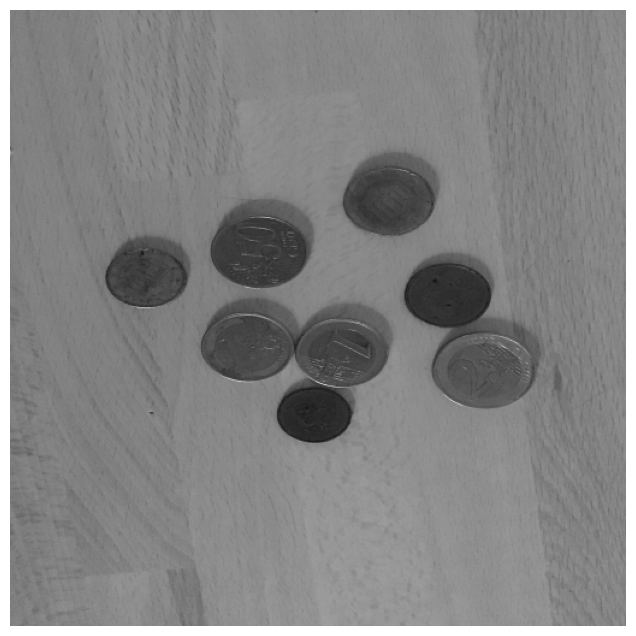

In [240]:
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

In [273]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [277]:
blurred = cv2.GaussianBlur(gray, (5, 5), 2)

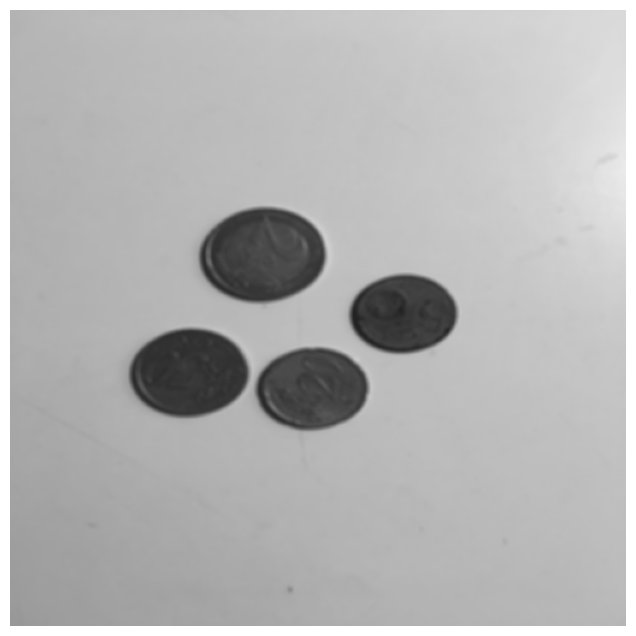

In [278]:
plt.figure(figsize=(8, 8))
plt.imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

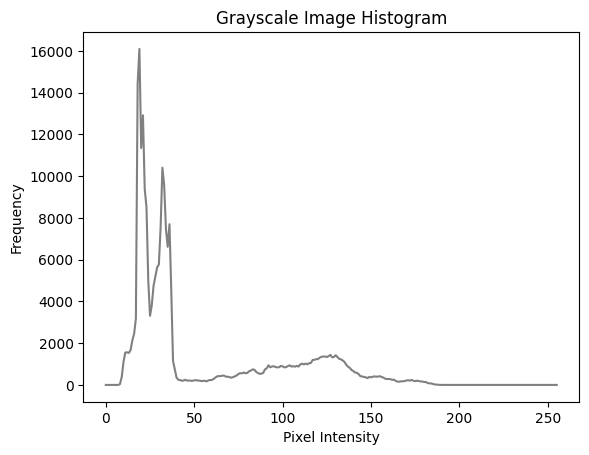

In [188]:
histogram = cv2.calcHist([blurred], [0], None, [256], [0, 256])

plt.plot(histogram, color='gray')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Grayscale Image Histogram')
plt.show()

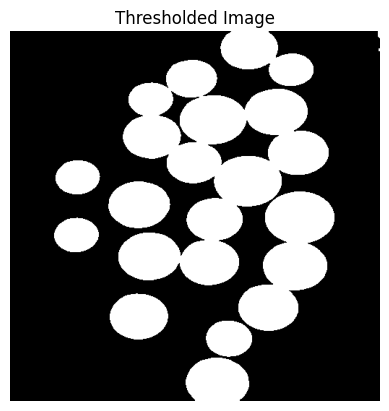

In [189]:
_, thresholded_image = cv2.threshold(blurred, 45, 185, cv2.THRESH_BINARY)

plt.imshow(thresholded_image, cmap='gray')
plt.title('Thresholded Image')
plt.axis('off')
plt.show()

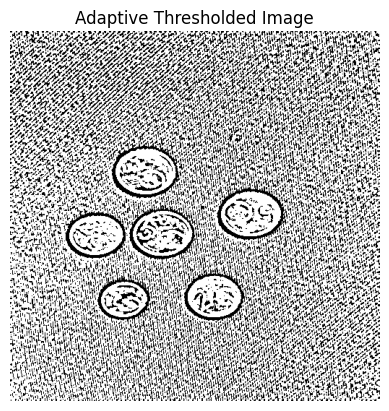

In [82]:
adaptive_thresholded_image = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

plt.imshow(adaptive_thresholded_image, cmap='gray')
plt.title('Adaptive Thresholded Image')
plt.axis('off')
plt.show()

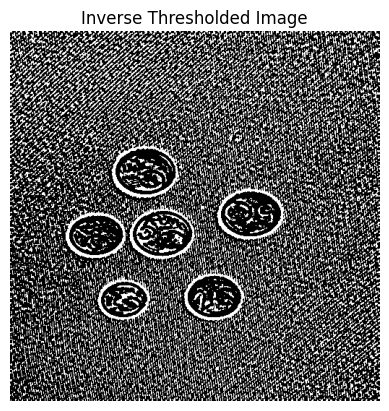

In [83]:
inverse_thresholded_image = cv2.bitwise_not(adaptive_thresholded_image)

plt.imshow(inverse_thresholded_image, cmap='gray')
plt.title('Inverse Thresholded Image')
plt.axis('off')
plt.show()

In [283]:
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

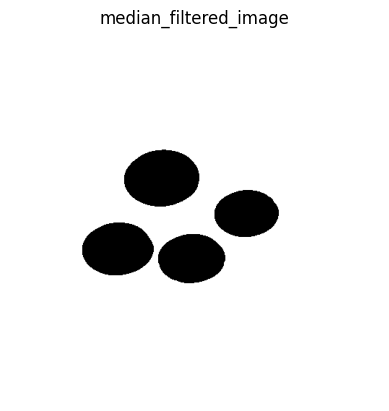

In [284]:
median_filtered_image = cv2.medianBlur(thresh, 5)

plt.imshow(median_filtered_image, cmap='gray')
plt.title('median_filtered_image')
plt.axis('off')
plt.show()

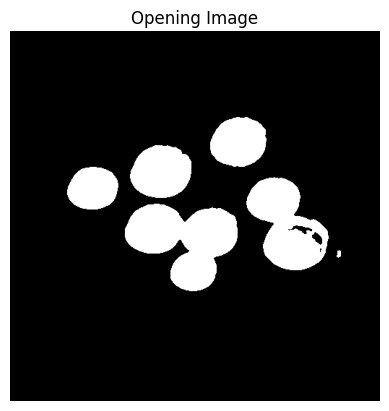

In [248]:
kernel_size = 5  

kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))

opening_image = cv2.morphologyEx(median_filtered_image, cv2.MORPH_OPEN, kernel)

plt.imshow(opening_image, cmap='gray')
plt.title('Opening Image')
plt.axis('off')
plt.show()

In [249]:
bg = cv2.dilate(opening_image,kernel,iterations=2)
dist_transform = cv2.distanceTransform(opening_image,cv2.DIST_L2,5)

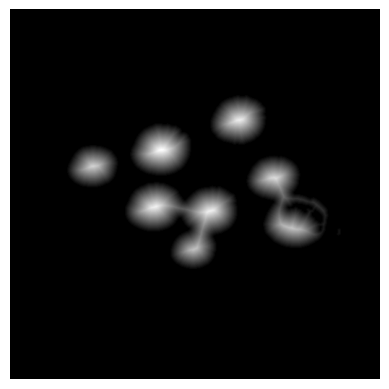

In [250]:
plt.imshow(dist_transform, cmap='gray')
plt.axis('off')
plt.show()

In [251]:
ret, fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

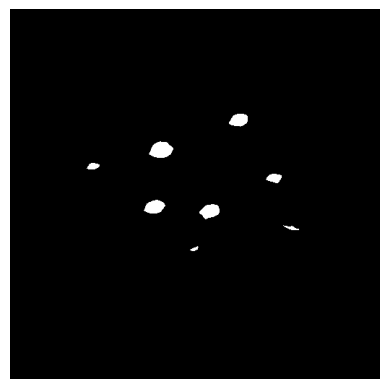

In [252]:
plt.imshow(fg, cmap='gray')
plt.axis('off')
plt.show()

In [253]:
fg = np.uint8(fg)
unknown = cv2.subtract(bg,fg)

In [255]:
# Marker labelling
ret, markers = cv2.connectedComponents(fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0

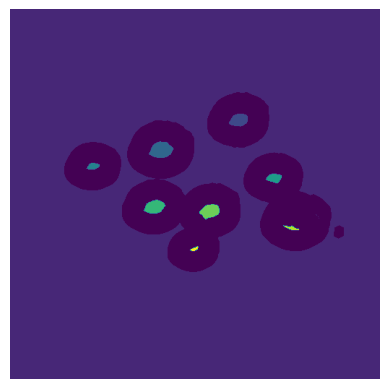

In [256]:
plt.imshow(markers)
plt.axis('off')
plt.show()

In [257]:
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]

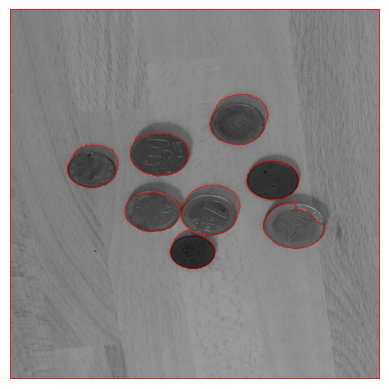

In [258]:
plt.imshow(img)
plt.axis('off')
plt.show()

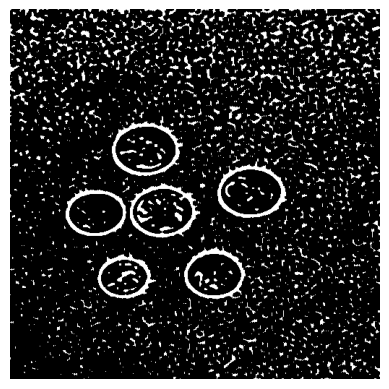

In [86]:
closing_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
processed_image = cv2.morphologyEx(median_filtered_image, cv2.MORPH_CLOSE, closing_kernel)
plt.imshow(processed_image, cmap='gray')
plt.axis('off')
plt.show()

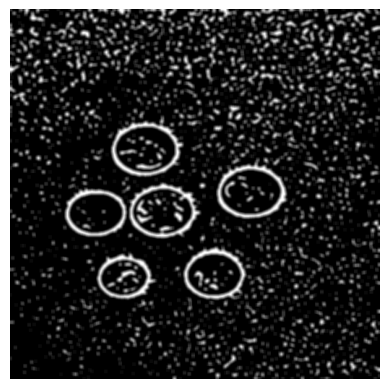

In [87]:
filtered_image = cv2.blur(processed_image, (5,5))
plt.imshow(filtered_image, cmap='gray')
plt.axis('off')
plt.show()

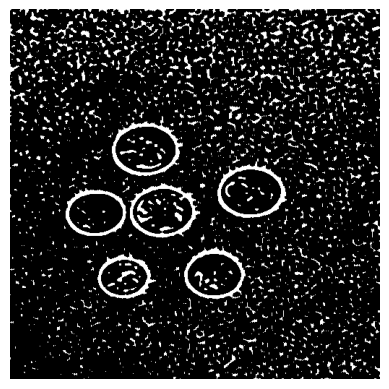

In [88]:
plt.imshow(processed_image, cmap='gray')
plt.axis('off')
plt.show()

In [97]:
img = images["ImgPiece4.jpeg"]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(512,512),interpolation=cv2.INTER_AREA)

[[[332.5 247.5  41.9]
  [214.5 268.5  47.1]
  [281.5 374.5  37.7]
  [161.5 366.5  28. ]
  [118.5 282.5  32.9]
  [188.5 193.5  37.2]
  [296.5  71.5  33.8]
  [245.5  44.5  31.4]
  [377.5 107.5  27.5]
  [ 74.5 110.5  36.3]]]


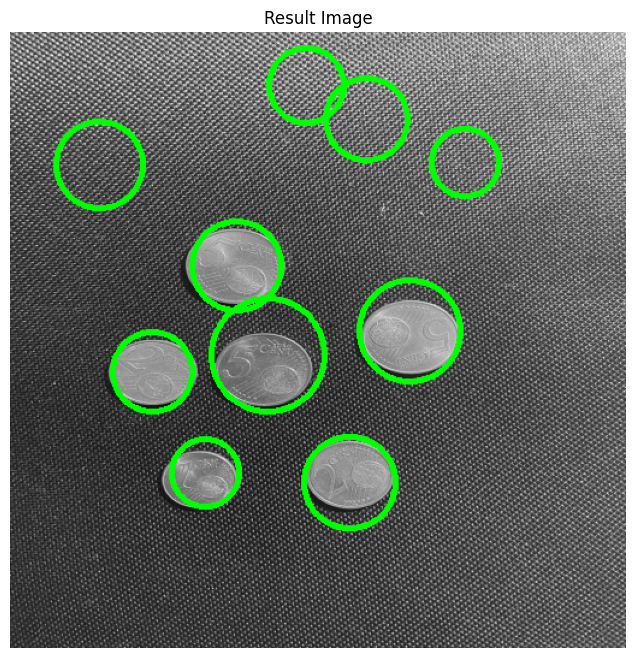

In [98]:
circles = cv2.HoughCircles(processed_image, cv2.HOUGH_GRADIENT, dp=1, minDist=50,
                           param1=50, param2=30, minRadius=15, maxRadius=70)
print(circles)
if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        cv2.circle(img, (x, y), r, (0, 255, 0), 4)

plt.figure(figsize=(8, 8)) 

plt.imshow(img)
plt.title('Result Image')
plt.axis('off')
plt.show()

'Dark'